Polarisation

Read in data

In [6]:
import matplotlib.pyplot as plt
import itertools
import json
import numpy as np
from pylhe import read_lhe_with_attributes, read_num_events
### Defining Functions
import itertools
import json


def extract_particle_data(lhe_file, particle_ids):
    """Extract data for specific particle IDs from the LHE file."""
    events = read_lhe_with_attributes(lhe_file)
    num_events = read_num_events(lhe_file)
    print(f"Number of events: {num_events}")

    particle_data = []

    # Ensure particle_ids is a list
    if not isinstance(particle_ids, list):
        particle_ids = [particle_ids]

    for event_index, event in enumerate(itertools.islice(events, num_events)):
        for particle in event.particles:
            # Corrected condition
            if particle.id in particle_ids:  
                particle_data.append({
                    'event': event_index,
                    'id': particle.id,
                    'px': particle.px,
                    'py': particle.py,
                    'pz': particle.pz,
                    'E': particle.e,
                    'status': particle.status
                })

    return particle_data


import math

def extract_kinematic_data(particle_data):
    """Extract transverse momentum (pT), pseudorapidity (eta), and azimuthal angle (phi) for each particle."""
    kinematic_data = []


    for particle in particle_data:
        px, py, pz = particle['px'], particle['py'], particle['pz']


        pt = math.sqrt(px**2 + py**2)


        phi = math.atan2(py, px)


        theta = math.acos(pz / math.sqrt(px**2 + py**2 + pz**2))
        eta = -math.log(math.tan(theta / 2))


        kinematic_data.append({
            'pt': pt,
            'eta': eta,
            'phi': phi,
        })

    return kinematic_data

### Importing Data
lhe_file = r"C:\Users\gabri\OneDrive\Documents\University\Mphys\TriBoson\Week4\unweighted_events.lhe"

w_data = extract_particle_data(lhe_file, particle_ids=[24]) #W+
w_anti_data = extract_particle_data(lhe_file, particle_ids=[-24]) #W-
z_data = extract_particle_data(lhe_file, particle_ids=[23])
muon_data = extract_particle_data(lhe_file, particle_ids=[13])
muon_anti_data = extract_particle_data(lhe_file, particle_ids=[-13])


import numpy as np
import vector

z_momentum = vector.array({
    "E": [data["E"] for data in z_data],
    "x": [data["px"] for data in z_data],
    "y": [data["py"] for data in z_data],
    "z": [data["pz"] for data in z_data]
})

w_momentum = vector.array({
    "E": [data["E"] for data in w_data],
    "x": [data["px"] for data in w_data],
    "y": [data["py"] for data in w_data],
    "z": [data["pz"] for data in w_data]
})

w_anti_momentum = vector.array({
    "E": [data["E"] for data in w_anti_data],
    "x": [data["px"] for data in w_anti_data],
    "y": [data["py"] for data in w_anti_data],
    "z": [data["pz"] for data in w_anti_data]
})

muon_momentum = vector.array({
    "E": [data["E"] for data in muon_data],
    "x": [data["px"] for data in muon_data],
    "y": [data["py"] for data in muon_data],
    "z": [data["pz"] for data in muon_data]
})

muon_anti_momentum = vector.array({
    "E": [data["E"] for data in muon_anti_data],
    "x": [data["px"] for data in muon_anti_data],
    "y": [data["py"] for data in muon_anti_data],
    "z": [data["pz"] for data in muon_anti_data]
})


Number of events: 10000
Number of events: 10000
Number of events: 10000
Number of events: 10000
Number of events: 10000


Define functions to calculate a unit vector to rotate about using a cross product, calculate the angle of rotation through a dot product and then to do the rotation to align it with the z axis

In [7]:
import vector


class Vector3D:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def magnitude(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

    def normalize(self):
        mag = self.magnitude()
        if mag > 0:
            return Vector3D(self.x / mag, self.y / mag, self.z / mag)
        else:
            return Vector3D(0, 0, 0)  # Or handle the zero vector case appropriately

    def __repr__(self):
        return f"Vector3D({self.x}, {self.y}, {self.z})"

    @staticmethod
    def from_array(arr):
        return Vector3D(arr[0], arr[1], arr[2])

# Function to compute cross product and return normalized vectors as Vector3D instances
def crossproduct(vectors):
    crossproduct_results = []
    
    for particle in vectors:
        # Assuming particle is an object with x, y, z attributes
        px, py, pz = particle.x, particle.y, particle.z
        
        # Define the fixed vector (for example, the Z-axis)
        fixed_vector = np.array([0, 0, 1])  # Modify as needed
        
        # Create the particle vector as a NumPy array
        particle_vector = np.array([px, py, pz])
        
        # Calculate the cross product
        cross_product = np.cross(particle_vector, fixed_vector)
        
        # Normalize the cross product vector
        normalized_vector = Vector3D.from_array(cross_product).normalize()
        
        crossproduct_results.append(normalized_vector)
    
    return crossproduct_results

def dotproduct(vector):
    angles=[]
    for particle in vector:
        z_axis = np.array([0,0,1])
        px, py, pz = particle.x, particle.y, particle.z
        particle_vector = np.array([px, py, pz])

        dot = np.dot(particle_vector, z_axis)
        angle = np.arccos(dot/np.sqrt(px**2 + py**2 + pz**2))
        angles.append(angle)
    return angles

def rotation(vectors, unit_vectors, thetas):
    rotated_x = []
    rotated_y = []
    rotated_z = []
    rotated_E = []
    

    for i, (vector_i, unit_vector_i) in enumerate(zip(vectors, unit_vectors)):
        # Retrieve theta for the current vector from angles
        theta = thetas[i]
        
        # Calculate the rotated coordinates using the rotation matrices
        x_new = (
            (np.cos(theta) + (1 - np.cos(theta)) * unit_vector_i.x**2) * vector_i.x 
            + (unit_vector_i.x * unit_vector_i.y * (1 - np.cos(theta))) * vector_i.y 
            + unit_vector_i.y * np.sin(theta) * vector_i.z
        )
        
        y_new = (
            unit_vector_i.x * unit_vector_i.y * (1 - np.cos(theta)) * vector_i.x
            + (np.cos(theta) + (1 - np.cos(theta)) * unit_vector_i.y**2) * vector_i.y
            - unit_vector_i.x * np.sin(theta) * vector_i.z
        )
        
        z_new = (
            -unit_vector_i.y * np.sin(theta) * vector_i.x
            + unit_vector_i.x * np.sin(theta) * vector_i.y 
            + np.cos(theta) * vector_i.z
        )
        
        # Append rotated coordinates to the output lists
        rotated_x.append(x_new)
        rotated_y.append(y_new)
        rotated_z.append(z_new)
        rotated_E.append(vector_i.E)
    # Return as a vector array object if supported or convert it to a dictionary structure
    return vector.array({
        'x': np.array(rotated_x),
        'y': np.array(rotated_y),
        'z': np.array(rotated_z),
        'E': np.array(rotated_E)
    })


COM frame

In [8]:
COM_OG = w_momentum + w_anti_momentum + z_momentum

COM_unit_vectors = crossproduct(COM_OG)
COM_angles = dotproduct(COM_OG)

COM_rotated = rotation(COM_OG, COM_unit_vectors, COM_angles)
COM_rotated_boost_vector = COM_rotated.to_beta3()


Move Z and muons to COM frame

In [9]:

Z_rotated_lab = rotation(z_momentum, COM_unit_vectors, COM_angles)
Z_in_COM_frame = Z_rotated_lab.boost(-COM_rotated_boost_vector)

muon_rotated_lab = rotation(muon_momentum, COM_unit_vectors, COM_angles)
muon_in_COM_frame = muon_rotated_lab.boost(-COM_rotated_boost_vector)



Calculate the the Z boost and rotation

In [10]:

Z_angles = dotproduct(Z_in_COM_frame)
Z_unit_vector = crossproduct(Z_in_COM_frame)
Z_rotated_COM_frame = rotation(Z_in_COM_frame, Z_unit_vector, Z_angles)
Z_boost_vector = Z_rotated_COM_frame.to_beta3()

Get muon into Z frame

In [11]:
muons_rotated_in_COM_frame = rotation(muon_in_COM_frame, Z_unit_vector, Z_angles)
muons_Z_frame = muons_rotated_in_COM_frame.boost(-Z_boost_vector)

Plot Histogram

10000


<function matplotlib.pyplot.show(close=None, block=None)>

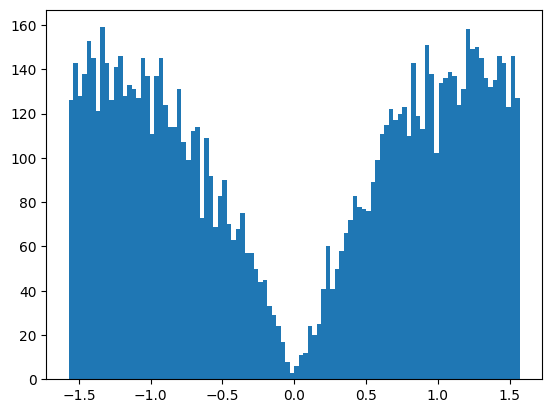

In [ ]:
theta = np.arctan((np.sqrt(muons_Z_frame.px**2 + muons_Z_frame.py**2))/muons_Z_frame.pz)
print(len(theta))
plt.hist(theta, bins=100)
plt.show

Check Rotation

In [13]:
simple_vecs = [
    vector.array({'E': [1000], 'x': [100000], 'y': [1000], 'z': [100000]}),  # Along x-axis
    vector.array({'E': [1], 'x': [0], 'y': [1], 'z': [0]}),  # Along y-axis
    vector.array({'E': [1], 'x': [1], 'y': [1], 'z': [1]}),  # Along z-axis
]

for vec in simple_vecs:
    
    angles = dotproduct(vec)
    unit = crossproduct(vec)
    z_axis = rotation(vec, unit, angles)
    print(vec[0])
    print(z_axis[0])
    print(angles[0])


MomentumObject4D(px=100000.0, py=1000.0, pz=100000.0, E=1000.0)
MomentumObject4D(px=1.4551915228366852e-11, py=0.0, pz=141424.89172702236, E=1000.0)
0.7854231621475212
MomentumObject4D(px=0.0, py=1.0, pz=0.0, E=1.0)
MomentumObject4D(px=0.0, py=6.123233995736766e-17, pz=1.0, E=1.0)
1.5707963267948966
MomentumObject4D(px=1.0, py=1.0, pz=1.0, E=1.0)
MomentumObject4D(px=1.1102230246251565e-16, py=1.1102230246251565e-16, pz=1.7320508075688772, E=1.0)
0.9553166181245092


Invarient mass calc. function

In [14]:
def inv_mass_equation(vector):
    """Calculate the invariant mass for a given 4D vector."""
    # Ensure we do not take the square root of a negative number
    mass_squared = vector.E**2 - (vector.px**2 + vector.py**2 + vector.pz**2)
    return np.sqrt(np.maximum(mass_squared, 0))  # Avoid negative values

def inv_mass_function(vectors):
    """Calculate the invariant mass for an array of 4D vectors."""
    # Use a list comprehension to calculate the invariant mass for each vector
    return np.array([inv_mass_equation(vector) for vector in vectors])


Invarient mass check function

In [15]:
def check_invariant_mass_equal(vectors_set_1, vectors_set_2, tolerance=1.0):
    """
    Check if the invariant mass of two sets of 4D vectors are equal within a specified tolerance.

    Parameters:
    vectors_set_1 (list of Vector4D): The first set of vectors.
    vectors_set_2 (list of Vector4D): The second set of vectors.
    tolerance (float): The tolerance level for the invariant mass comparison (default is 1 GeV).

    Returns:
    bool: True if the invariant masses are equal within the tolerance, False otherwise.
    """
    # Calculate invariant masses for both sets
    inv_mass_1 = inv_mass_function(vectors_set_1)
    inv_mass_2 = inv_mass_function(vectors_set_2)

    # Check if the lengths of the invariant mass arrays are the same
    if len(inv_mass_1) != len(inv_mass_2):
        raise ValueError("The two sets of vectors must have the same length.")

    # Compare invariant masses within the tolerance
    for mass_1, mass_2 in zip(inv_mass_1, inv_mass_2):
        if not np.isclose(mass_1, mass_2, atol=tolerance):
            return False  # If any pair of invariant masses are not close enough, return False

    return True  # All invariant masses are equal within the tolerance


Check inv mass

In [16]:
result = check_invariant_mass_equal(z_momentum, Z_rotated_COM_frame.boost(-Z_boost_vector), tolerance=1)

# Print the result
print("Invariant masses of Z before and after transformations are equal within tolerance:", result)

muon_check = check_invariant_mass_equal(muon_momentum, muons_Z_frame, tolerance=1)

# Print the result
print("Invariant masses of muon before and after transformations are equal within tolerance:", muon_check)

com_check = check_invariant_mass_equal(COM_OG, COM_rotated, tolerance=1)

# Print the result
print("Invariant masses of muon before and after transformations are equal within tolerance:", com_check)

Invariant masses of Z before and after transformations are equal within tolerance: True
Invariant masses of muon before and after transformations are equal within tolerance: True
Invariant masses of muon before and after transformations are equal within tolerance: True


Check Z boost and momentum

In [17]:
Z_check = Z_rotated_COM_frame_fourvec.boost(-Z_boost_vector)
print(z_momentum)
print(Z_check)

result = check_invariant_mass_equal(z_momentum, Z_rotated_COM_frame_fourvec, tolerance=10)

# Print the result
print("Invariant masses of Z before and after transformations are equal within tolerance:", result)




NameError: name 'Z_rotated_COM_frame_fourvec' is not defined

Check muon and antimuon momentums add to Zero

In [54]:
Anti_muon_rotated_lab_frame = rotation(muon_anti_momentum, COM_unit_vectors, COM_angles)
Anti_muon__COM_frame = Anti_muon_rotated_lab_frame.boost(-COM_rotated_boost_vector)
Anti_muon_rotated_COM_frame = rotation(Anti_muon__COM_frame,Z_unit_vector, Z_angles)
Anti_muon_Z_frame = Anti_muon_rotated_COM_frame.boost(-Z_boost_vector)

check = Anti_muon_Z_frame + muons_Z_frame
print(check)

[( 1.15019105e-13,  6.67910172e-13, -3.33102435e-11,  90.31943382)
 (-8.23385804e-10, -6.31459329e-10,  1.18980381e-10,  89.31701382)
 ( 2.55069832e-09, -2.40097364e-09,  1.12115856e-07,  90.25517658) ...
 ( 1.54348454e-08,  9.56930890e-09, -1.19452039e-08,  91.1051417 )
 (-7.64657671e-10,  2.19479546e-10, -7.44074669e-09, 101.62198011)
 (-1.41832146e-09,  3.21931637e-09, -3.61496433e-09,  90.0558742 )]
